In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.utils import plot_model

In [2]:
!nvidia-smi

Thu May  6 16:08:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   29C    P8    16W / 150W |      0MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
base_dir = './findog'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 10957 images belonging to 121 classes.
Found 2679 images belonging to 121 classes.
Found 0 images belonging to 1 classes.


IndexError: list index out of range

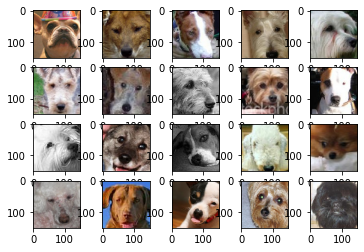

In [4]:
fig = plt.figure()
fig_arr = []
for i in range(20):
    fig_arr.append(fig.add_subplot(4,5,i+1))

for data_batch, lable_batch in train_generator:
    for idx, img_data in enumerate(data_batch):
        fig_arr[idx].imshow(img_data, cmap='gray')
    break

plt.tight_layout()
plt.show()

# 전이 학습

In [5]:
# pretrained network
model_base = EfficientNetB7(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

258080768/258076736 [==============================] - 7s 0us/step
Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
__________________

In [6]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(120, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 5, 5, 2560)        64097687  
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               7680120   
Total params: 71,777,807
Trainable params: 7,680,120
Non-trainable params: 64,097,687
_________________________________________________________________


# Fine Tuning

In [ ]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

In [ ]:
'''
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/융합프로젝트.png')'''

In [7]:
history = model.fit(train_generator, steps_per_epoch=109, epochs=30,
                    validation_data=validation_generator, validation_steps=26)

Epoch 1/30
109/109 [==============================] - 154s 1s/step - loss: 8.3721 - accuracy: 0.0085 - val_loss: 5.9011 - val_accuracy: 0.0108
Epoch 2/30
109/109 [==============================] - 128s 1s/step - loss: 7.5052 - accuracy: 0.0078 - val_loss: 5.8387 - val_accuracy: 0.0092
Epoch 3/30
109/109 [==============================] - 128s 1s/step - loss: 7.4957 - accuracy: 0.0097 - val_loss: 5.5887 - val_accuracy: 0.0069
Epoch 4/30
109/109 [==============================] - 128s 1s/step - loss: 7.3384 - accuracy: 0.0096 - val_loss: 6.0080 - val_accuracy: 0.0123
Epoch 5/30
109/109 [==============================] - 128s 1s/step - loss: 7.4583 - accuracy: 0.0070 - val_loss: 5.7940 - val_accuracy: 0.0119
Epoch 6/30
109/109 [==============================] - 128s 1s/step - loss: 7.3770 - accuracy: 0.0084 - val_loss: 5.7267 - val_accuracy: 0.0085
Epoch 7/30
109/109 [==============================] - 128s 1s/step - loss: 7.2719 - accuracy: 0.0098 - val_loss: 5.6396 - val_accuracy: 0.0112

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


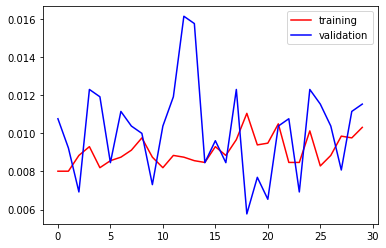

In [8]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_acc.jpg')
plt.show()

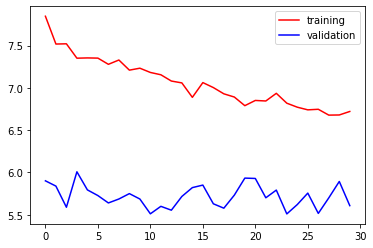

In [9]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
#plt.savefig('./models/InceptionResNetV2_1/InceptionResNetV2_1-1_val.jpg')
plt.show()

In [10]:
result = model.evaluate(validation_generator)
print(np.round(result, 4))

27/27 [==============================] - 27s 978ms/step - loss: 5.6025 - accuracy: 0.0112
[5.6025 0.0112]


In [ ]:
#model.save('./models/InceptionResNetV2_1/InceptionResNetV2_1-1.h5')